In [1]:
import torch
from mutect3 import data, validation, tensors, networks

%matplotlib inline

In [7]:
GENERATE_PICKLES = True
if GENERATE_PICKLES:
    table_dir = '/Users/davidben/broad/mutect3/tables/'
    pickle_dir = '/Users/davidben/broad/mutect3/pickles/'
    dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
    tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
    normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

    for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
        print("Generating tensors for " + dream)

        tumor_table, normal_table = (table_dir + dream + suffix for suffix in ('-tumor.table', '-normal.table'))
        pair_train_pickle, small_pair_train_pickle, tumor_train_pickle, normal_train_pickle, test_pickle, small_test_pickle = \
            (pickle_dir + dream + suffix for suffix in ('-pair-train.pickle', '-small-pair-train.pickle', '-tumor-train.pickle', \
                                                       '-normal-train.pickle', '-test.pickle', '-small-test.pickle'))

        # we form a few kinds of training data: tumor data using the normal 
        # (the normal doesn't change the format but helps make better truth guesses)
        print("Generating and pickling tumor tensors for training using tumor and normal")
        pair_train_data = tensors.make_tensors(tumor_table, True, tumor_sample, normal_sample)
        tensors.make_pickle(pair_train_pickle, pair_train_data)

        print("Generating and pickling small (by 10x) tumor tensors for training using tumor and normal")
        tensors.make_pickle(small_pair_train_pickle, pair_train_data[:int(len(pair_train_data)/10)])

        print("Generating and pickling tumor tensors for training using only tumor")
        tumor_train_data = tensors.make_tensors(tumor_table, True, tumor_sample)
        tensors.make_pickle(tumor_train_pickle, tumor_train_data)

        print("Generating and pickling normal tensors for training using only normal")
        normal_train_data = tensors.make_tensors(normal_table, True, normal_sample)
        tensors.make_pickle(normal_train_pickle, normal_train_data)

        print("Generating and pickling tumor tensors for testing using STATUS labels")
        test_data = tensors.make_tensors(tumor_table, False, tumor_sample, normal_sample)
        tensors.make_pickle(test_pickle, test_data)

        print("Generating and pickling small (by 10x) tumor tensors for for testing using STATUS labels")
        tensors.make_pickle(small_test_pickle, test_data[:int(len(test_data)/10)])

Generating tensors for dream1
Generating and pickling tumor tensors for training using tumor and normal
Processing line 0
Processing line 100000
Processing line 200000
Processing line 300000
Processing line 400000
Processing line 500000
Processing line 600000
Processing line 700000
Processing line 800000
Processing line 900000
Processing line 1000000
Processing line 1100000
Processing line 1200000
Processing line 1300000
Processing line 1400000
Processing line 1500000
Processing line 1600000
Processing line 1700000
Processing line 1800000
Processing line 1900000
Processing line 2000000
Processing line 2100000
Processing line 2200000
Processing line 2300000
Processing line 2400000
Processing line 2500000
Processing line 2600000
Processing line 2700000
Processing line 2800000
Processing line 2900000
Processing line 3000000
Processing line 3100000
Processing line 3200000
Processing line 3300000
Processing line 3400000
Processing line 3500000
Processing line 3600000
Processing line 3700000

Processing line 4400000
Processing line 4500000
Processing line 4600000
Processing line 4700000
Processing line 4800000
Processing line 4900000
Generating and pickling tumor tensors for testing using STATUS labels
Processing line 0
Processing line 100000
Processing line 200000
Processing line 300000
Processing line 400000
Processing line 500000
Processing line 600000
Processing line 700000
Processing line 800000
Processing line 900000
Processing line 1000000
Processing line 1100000
Processing line 1200000
Processing line 1300000
Processing line 1400000
Processing line 1500000
Processing line 1600000
Processing line 1700000
Processing line 1800000
Processing line 1900000
Processing line 2000000
Processing line 2100000
Processing line 2200000
Processing line 2300000
Processing line 2400000
Processing line 2500000
Processing line 2600000
Processing line 2700000
Processing line 2800000
Processing line 2900000
Processing line 3000000
Processing line 3100000
Processing line 3200000
Processin

Processing line 2000000
Processing line 2100000
Processing line 2200000
Processing line 2300000
Processing line 2400000
Processing line 2500000
Processing line 2600000
Processing line 2700000
Processing line 2800000
Processing line 2900000
Processing line 3000000
Processing line 3100000
Processing line 3200000
Processing line 3300000
Processing line 3400000
Processing line 3500000
Processing line 3600000
Processing line 3700000
Processing line 3800000
Processing line 3900000
Processing line 4000000
Processing line 4100000
Processing line 4200000
Processing line 4300000
Processing line 4400000
Generating and pickling tumor tensors for testing using STATUS labels
Processing line 0
Processing line 100000
Processing line 200000
Processing line 300000
Processing line 400000
Processing line 500000
Processing line 600000
Processing line 700000
Processing line 800000
Processing line 900000
Processing line 1000000
Processing line 1100000
Processing line 1200000
Processing line 1300000
Processin

In [8]:
BATCH_SIZE = 64
def run_evaluation(training_pickles, test_pickle, num_epochs):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = data.make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect_info().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    # Learn model
    train_loader, valid_loader, test_loader = data.make_data_loaders(train, valid, test)
    model = networks.ReadSetClassifier([20, 20], [10, 10], [10], [], {'normal_artifact'}).float()
    training_metrics = model.train_model(train_loader, valid_loader, test_loader, num_epochs, BATCH_SIZE)
    training_metrics.plot_all_metrics()
    model.get_prior_model().plot_spectra()
    
    #plot purported ROC curve
    validation.get_optimal_f_score(model, test_loader, make_plot=True)

    logit_threshold = model.calculate_logit_threshold(test_loader)
    print("Optimal logit threshold: " + str(logit_threshold))
    
    validation.show_validation_plots(model, test_loader, logit_threshold)

    return model
        

In [9]:
DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_1_SMALL_PAIR = DIR + 'dream1-small-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_1_SMALL_TEST = DIR + 'dream1-small-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

Loading datasets from pickled files
Dataset sizes -- training: 17221, validation: 1914, test: 1764
Training data includes 0 PASS variants labelled as artifacts.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Confidence params before calibration: 
[0.0, 1.02953040599823, 1.7135429382324219, 2.226412057876587, 2.4218225479125977, 2.602550506591797, 2.4194676876068115, 2.890435218811035, 2.707324266433716, 2.9991376399993896, 3.2565298080444336]
Confidence params after calibration: 
[0.0, 2.543114423751831, 2.5604779720306396, 4.778721332550049, 2.6531691551208496, 3.620306968688965, 4.0309224128723145, 4.601749897003174, 2.580324411392212, 4.541431427001953, 1.8746083974838257]
Prior log odds: 4.0
Prior log odds: 2.2636029720306396
Prior log odds: 1.4622318744659424
Prior log odds: 1.2101125717163086
Prior log odds: 1.1453088521957397
Prior log odds: 1.1291214227676392
Prior log odds: 1.124701738357544
Prior log odds: 1.1232062578201294
Prior log odds: 1.122550368309021
Prior log odds: 1.122225

ReadSetClassifier(
  (phi): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (bn): ModuleList()
  )
  (omega): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
    )
    (bn): ModuleList()
  )
  (rho): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=50, out_features=10, bias=True)
    )
    (bn): ModuleList()
  )
  (snv_output): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (bn): ModuleList()
  )
  (insertion_output): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (bn): ModuleList()
  )
  (deletion_output): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (bn): ModuleList()
  )
  (prior_model): 

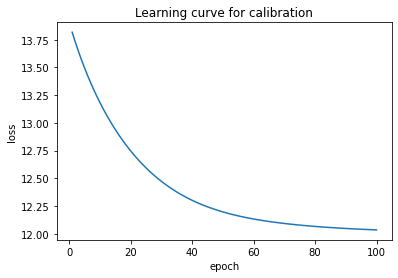

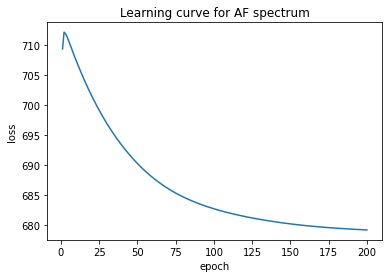

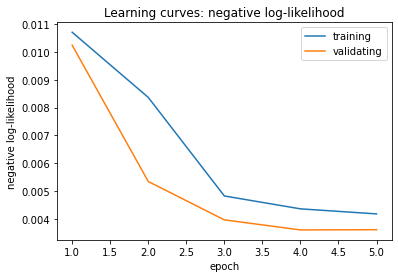

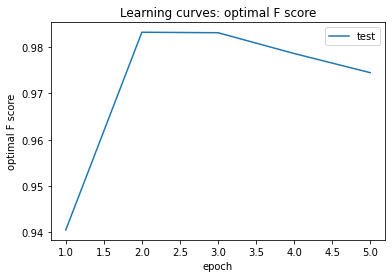

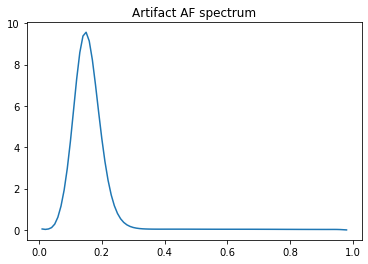

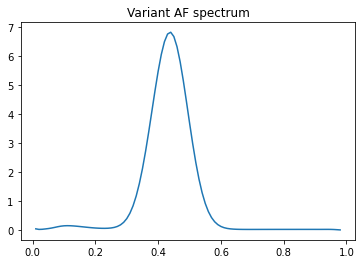

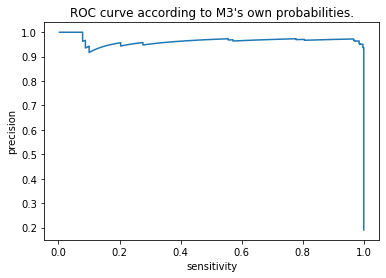

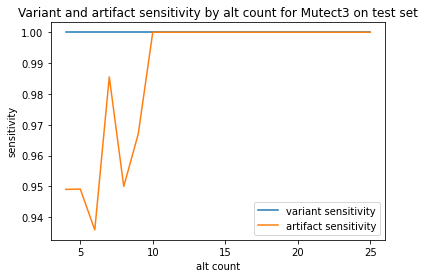

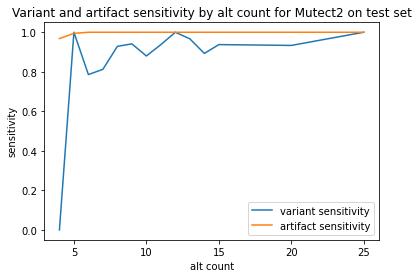

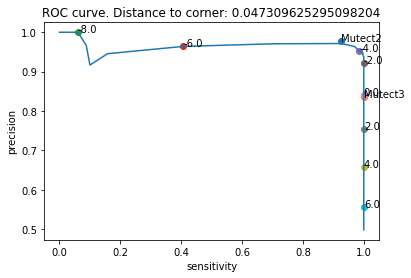

In [10]:
run_evaluation([DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST, 5)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 16 PASS variants labelled as artifacts.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Confidence params before calibration: 
[0.0, 3.690770149230957, 2.2984979152679443, 3.70969557762146, 3.237995147705078, 2.7957630157470703, 2.605414390563965, 3.2409727573394775, 2.4151759147644043, 2.3795173168182373, 2.3186118602752686]
Confidence params after calibration: 
[0.0, 2.0484261512756348, 1.956419587135315, 2.193603992462158, 3.307093620300293, 2.2302322387695312, 2.56746315956

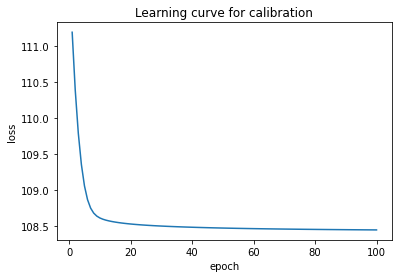

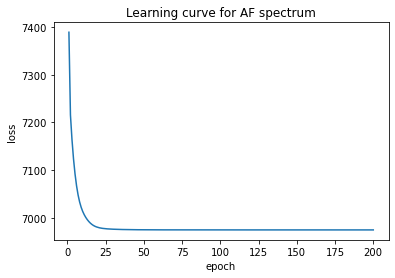

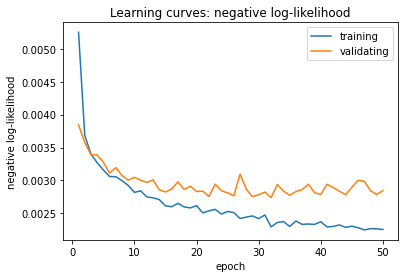

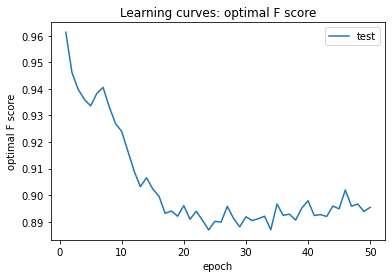

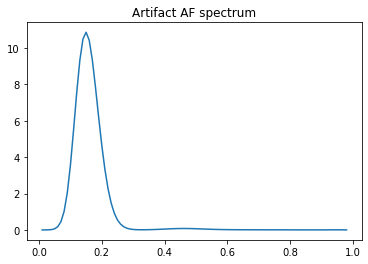

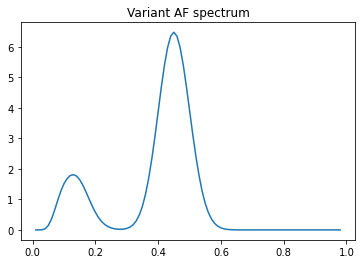

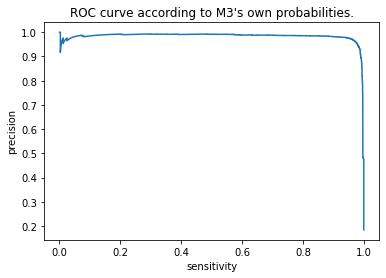

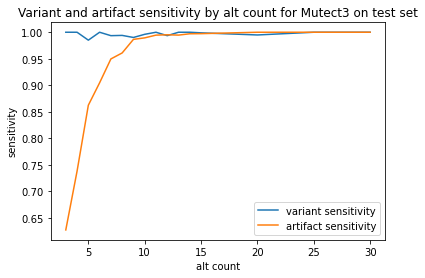

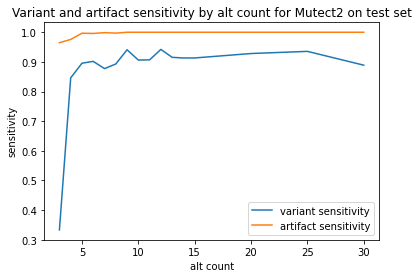

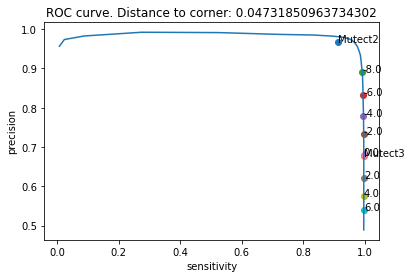

In [11]:
trained_model = run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 50)

In [12]:
trained_model.confidence, trained_model.max_logit

(Parameter containing:
 tensor([0.0000, 2.0484, 1.9564, 2.1936, 3.3071, 2.2302, 2.5675, 2.8461, 3.8681,
         2.4887, 2.4190]),
 Parameter containing:
 tensor(14.4533))

In [8]:
trained_model.confidence, trained_model.max_logit

Parameter containing:
tensor([0.0000, 1.3503, 3.6231, 3.3818, 2.6853, 2.7240, 3.6739, 3.2177, 2.2050,
        3.8816, 2.3083])

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_4_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_1_TEST, 50)